# Esimating power from  GPX file or Strava activity file 

Using Python Kernel 3.6
The purpose of this workbook is to create functions to address a range of issues.
- Firstly, suppose you only have a GPX file or you can't download an activity from Strava for a rider who has not given authorization, but you can download a GPX file of anyone's ride. It is possible to derive the missing statistics from this file, using weather data and rider data for the date of the ride.
- Secondly, suppose you get back from a ride and find that power was not recorded. It would be useful to estimate it.

The final version, the read_gpx function reads in a GPX file and estimates the speed, given the recording interval. You can then pull in weather observations for the date of the ride. The solveP function calculates power, using the rider's weight, weather conditions and any Cd or A provided (to allow for rider position or drafting). The solveP function also accounts for the effect of elevation on air pressure.


In [1]:
import pandas as pd
import numpy as np
from geopy.distance import vincenty
import matplotlib.pylab as plt
%matplotlib inline

import sys
stravaPath = '/Users/Gavin/Gavin/Jupyter/Strava'
sys.path.append(stravaPath)
weatherPath = '/Users/Gavin/Gavin/Jupyter/Weather'
sys.path.append(weatherPath)


import Strava_Download as strava
from AirDensity import rhoCalc
import HistoricWeather

##  Function to read a gpx file  
This function is used to estimate distance (modelD) in metres, speed (modelV) in m/s and slope (modelSlope), using only the data available in a GPX file, i.e. latitude, longitude and elevation. It makes use of the gpxpy module to calculate distances from the change in (lat, lon). It relies on knowing the recording frequency, dt, which is typically every one second. Smoothing is applied to reduce the effect of noisy data. The results are returned as a pandas dataframe.

In [2]:
import gpxpy as gp

def read_gpx(gpx_file='TDF_18_IZOARD.gpx', dt=1, smoothing=5):
    """Load a gpx file, assuming that data recording every dt seconds
    Return a pandas DataFrame with velocity, indexed in seconds"""
    gpx_file=open(gpx_file,'r')

    [lat,lon,elev]=[[],[],[]]
    gpx = gp.parse(gpx_file)
    gpx_file.close()

    for track in gpx.tracks: 
        for segment in track.segments:
            for point in segment.points:
                lat.append(point.latitude)
                lon.append(point.longitude)
                elev.append(point.elevation)

    course = pd.DataFrame({'lat': lat , 'lon':lon, 'altitude': elev})
    course['step'] = 0
    course['step'] = [0]+[vincenty((course.lat[i],course.lon[i]), (course.lat[i+1],course.lon[i+1])).m for i in range(len(course)-1)]
    # Set up model distance as index
    course['modelD'] = course.step.cumsum()/1000
    course['modelV'] = course.step.rolling(smoothing).mean()/dt
    
    course['modelSlope'] = (course.altitude.rolling(smoothing).mean().diff()/course.step.rolling(smoothing).mean()).rolling(smoothing).mean()*100 
    course.loc[course.step.rolling(smoothing).mean() < 1,'modelSlope'] = 0
    course.modelSlope = course.modelSlope.fillna(method='backfill')
    course.index = course.index*dt 
        
    return course


##  Functions to read a strava activity file
Since a strava activity file already has distance, velocity and slope series, these don't need to be calculated. The results are returned as a pandas dataframe.

In [3]:
def course_from_activity(activity_id = 1088096275): #1567745926
    activity = strava.get_strava_activity(activity_id)
    activity['step'] = activity.distance.diff()
    activity['distance'] = activity.distance.divide(1000)
    course = activity[['altitude','lat','lon','step','distance','velocity_smooth','grade_smooth']]
    course.columns=['altitude','lat','lon','step','modelD','modelV', 'modelSlope']
    return course


## Function to calculate power
The function uses A Differential Equation from the web site below, ignoring acceleration so d"(t) is zero

In [4]:
from IPython.display import IFrame
IFrame('https://analyticcycling.com/Glossary_Disc.html', width=700, height=500)

In [49]:
def solveP(course, dt=1, mr=74, Cd=0.5,  A=0.5, Br=0, Vw=0, Bw=0, Pressure=1020, Temp=15, DP=False, Humidity=False, 
           Crr=0.004, Cxf=0.0491, df=0.337*2, Cxr=0.0491, dr=0.337*2, RS=0.25, mb=8, mfw=1.264, mrw=1.364, g=9.81, 
           If = 0.0885, Ir = 0.1085, smoothing = 5, plotIt=False):
    """Returns course with calculated power for given set of parameters by solving linear equation
    Accounts for rider direction as a bearing Br, wind velicity Vw and wind direction (from) Bw"""

    dv = (course.modelV.diff(smoothing)/smoothing).rolling(smoothing).mean()/dt
    course['rho'] = course.altitude.apply(lambda x: rhoCalc(Pressure=Pressure, Temp=Temp, DP=DP, Humidity=Humidity, Elevation = x))
    Ahw = Vw * np.cos((Bw-Br)*np.pi/180) # Apparent headwind

    
    Drag = course.rho / 8 * (4 * A * Cd + np.pi * (Cxf * df**2 + Cxr * dr**2 * (1-RS) ))
    theta = np.arctan(course.modelSlope.rolling(smoothing).mean()/100)
    Mech = (mr + mb + mfw + mrw) * g * (Crr * np.cos(theta) + np.sin(theta))
    Acc = (mr + mb + mfw + mrw + 4 * If / df**2 + 4 * Ir / dr**2) * dv
    course['Power'] = (Drag * (course.modelV + Ahw)**2 + Mech + Acc ) * course.modelV
    course.Power = course.Power.apply(lambda x: max(0, x) )

    if plotIt:
        # Plots components in the power calculation
        plt.figure(figsize=(16,4))
        sm=10
        plt.plot((Drag * (course.modelV + Ahw)**2*course.modelV).rolling(sm).mean())
        plt.plot( (Mech*course.modelV).rolling(sm).mean(),c='r')
        plt.plot( (Acc*dv*course.modelV).rolling(sm).mean(),c='g')
        plt.plot(course.Power.rolling(sm).mean(),c='y')
        plt.ylim(-1000,1000)
        plt.show()
    
    return course

# Try it out
https://www.strava.com/activities/1614075487 This activity was a time trial so CdA was reduced from default 0.25 to 0.20, by setting frontal area, A, to 0.4. My power meter was not working so I don't have actual power

In [46]:
activity_id = 1614075487
courseP = course_from_activity(activity_id)
weather = strava.get_activity_weather(activity_id)
weather

No such attribute available_zones on entity <Activity id=1614075487 name='Time Trial P881/25 Smashed PB 54:35' resource_state=3>


Pressure                                     1019
Humidity                                       78
Temp                                           22
WindDirn                                      290
Wind                                            2
AirDensity                                1.00742
Name          Time Trial P881/25 Smashed PB 54:35
ID                                     1614075487
Longitude                                    -0.9
Latitude                                   51.055
Elevation                                    85.1
Name: 2018-06-03 07:49:13, dtype: object

In [47]:
courseP = solveP(courseP, dt=1, mr=74, Cd=0.5,  A=0.4, Br=0, Vw=4, Bw=90, Pressure=weather.Pressure, Temp=weather.Temp, DP=False, Humidity=weather.Humidity, 
           Crr=0.004, Cxf=0.0491, df=0.337*2, Cxr=0.0491, dr=0.337*2, RS=0.25, mb=8, mfw=1.264, mrw=1.364, g=9.81, 
           If = 0.0885, Ir = 0.1085, smoothing = 5, plotIt=False)

Estimated average power 319.09772406153087


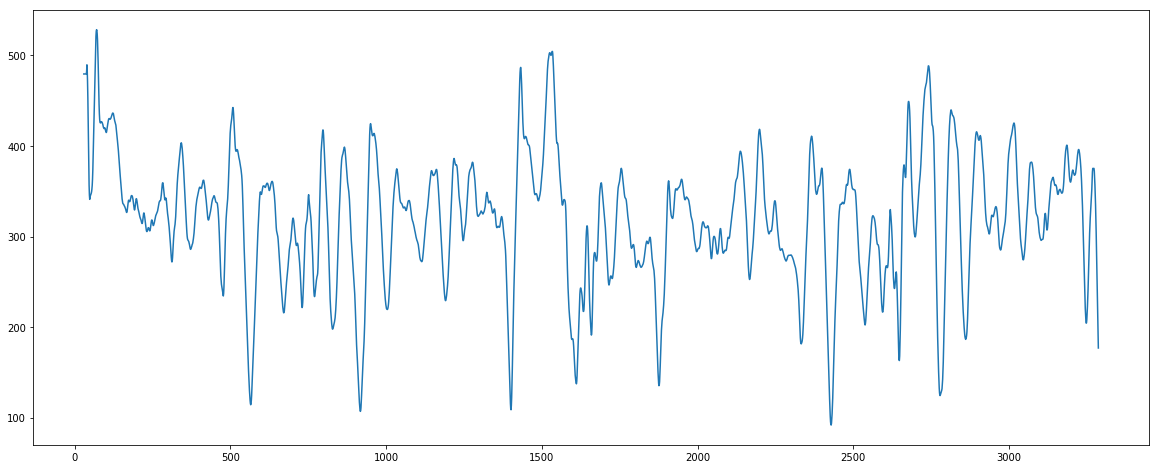

In [48]:
print(f'Estimated average power {courseP.Power.mean()}')
courseP.Power.rolling(30).mean().plot(figsize=(20,8))

## Test using some of my data

https://www.strava.com/activities/1088096275 This was a steady solo ride around Surrey

In this test, I compare three calculations of power (accounting for weather conditions)
- course.Power is calculated from the raw gpx file, by first working out distance, speed and slope
- courseP.Power is calculated from the strava activity file, which includes distance, speed and slope
- actual.Power is recorded during the ride


In [51]:
course = read_gpx(gpx_file='Afternoon_Ride 170717.gpx')
mr = 73
obs = HistoricWeather.weatherObs(d=17, m=7, y=2017, h=10, mi=0, s=0, town="london", country='uk')

course= solveP(course,mr=mr,Vw=0, Pressure=obs.Pressure, Temp=obs.Temp, Humidity=obs.Humidity )   

In [52]:
activity_id = 1088096275
actual = strava.get_strava_activity(activity_id)
courseP = course_from_activity(activity_id)
weather = strava.get_activity_weather(activity_id)
courseP = solveP(courseP, dt=1, mr=74, Cd=0.5,  A=0.5, Br=0, Vw=4, Bw=90, Pressure=weather.Pressure, Temp=weather.Temp, DP=False, Humidity=weather.Humidity, 
           Crr=0.004, Cxf=0.0491, df=0.337*2, Cxr=0.0491, dr=0.337*2, RS=0.25, mb=8, mfw=1.264, mrw=1.364, g=9.81, 
           If = 0.0885, Ir = 0.1085, smoothing = 5, plotIt=False)

No such attribute available_zones on entity <Activity id=1088096275 name='Afternoon Ride' resource_state=3>


There's a pretty good match for the 30 second smoothed power data.

(0, 600)

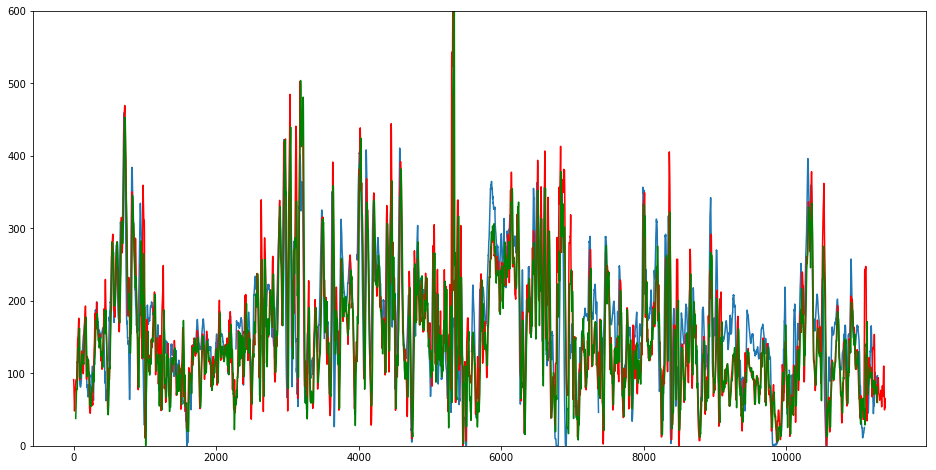

In [53]:
plt.figure(figsize=(16,8))
actual.watts.rolling(30).mean().plot()
course.Power.rolling(30).mean().shift(-120).plot(c='r')
courseP.Power.rolling(30).mean().plot(c='g')
plt.ylim((0,600))


In [14]:
actual.watts.mean(),course.Power.mean(),courseP.Power.mean()

(164.21481218364266, 157.35613089813663, 151.63776277213762)

In [15]:
actual.watts.rolling(60).mean().std(),course.Power.rolling(60).mean().std(),courseP.Power.rolling(60).mean().std()

(69.01122659024696, 72.56711869196852, 69.10494035626265)

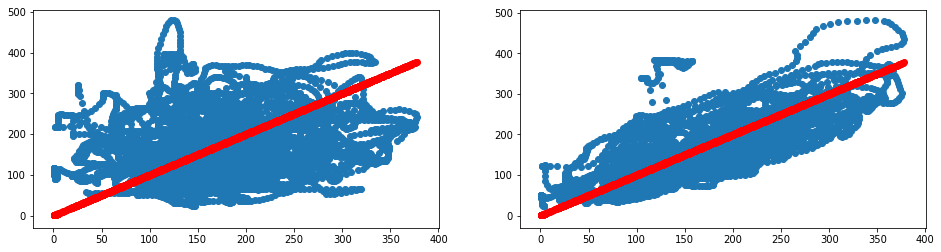

In [16]:
fig,ax=plt.subplots(1,2,figsize=(16,4))
n=len(actual.watts)
ax[0].scatter(x=actual.watts.rolling(60).mean(),y=course.Power.rolling(60).mean()[:n])
ax[0].scatter(x=actual.watts.rolling(60).mean(),y=actual.watts.rolling(60).mean(),c='r')
ax[1].scatter(x=actual.watts.rolling(60).mean(),y=courseP.Power.rolling(60).mean())
ax[1].scatter(x=actual.watts.rolling(60).mean(),y=actual.watts.rolling(60).mean(),c='r')


## Third test using some of my data

https://www.strava.com/activities/1092055102
- This was a race, so modelling power is tricky, due to frequent drafting behind others. The best way to account for this is to reduce Cd or reduce A, both have the effect of reducing CdA, which is the product of the two. In this example, bringing CdA down from 0.5\*0.5=0.25 to 0.42\*0.5=0.21 was reasonable

In [17]:
course = read_gpx(gpx_file='Hillingdon_Vets_bunch_picked_up_a_prime.gpx')

Summary of modelled velocity


count    4098.000000
mean       39.208338
std         9.466514
min         0.000000
25%        38.079458
50%        40.757209
75%        43.571954
max        78.700031
Name: modelV, dtype: float64

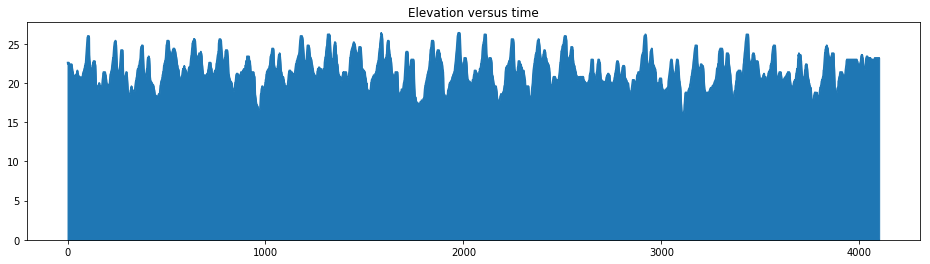

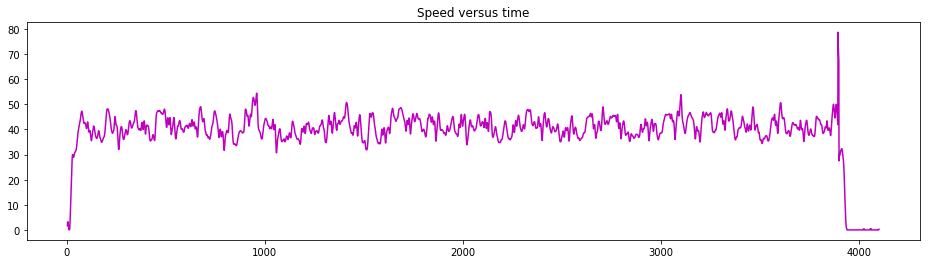

In [18]:
plt.figure(figsize=(16,4))
course.altitude.plot.area(title='Elevation versus time')
plt.figure(figsize=(16,4))
course.modelV.apply(lambda x: x*3.6).plot(c='m', title='Speed versus time')
print('Summary of modelled velocity')
course.modelV.apply(lambda x: x*3.6).describe()

In [19]:
mr = 73
obs = HistoricWeather.weatherObs(d=19, m=7, y=2017, h=19, mi=30, s=0, town="london", country='uk')
Cd = 0.42 # drafting
course = solveP(course,Cd=Cd, mr=mr,Vw=0, Pressure=obs.Pressure, Temp=obs.Temp, Humidity=obs.Humidity )   

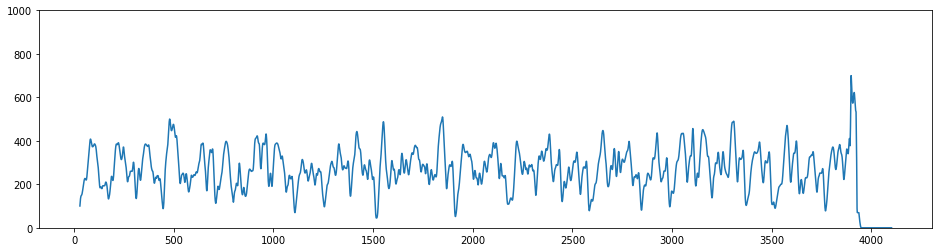

In [20]:
plt.figure(figsize=(16,4))

plt.ylim((0,1000))
course.Power.rolling(30).mean().plot()

In [21]:
activity_id = 1092055102
actual = strava.get_strava_activity(activity_id)
actual = strava.get_strava_activity(activity_id)
courseP = course_from_activity(activity_id)
weather = strava.get_activity_weather(activity_id)
courseP = solveP(courseP, dt=1, mr=74, Cd=Cd,  A=0.5, Br=0, Vw=4, Bw=90, Pressure=weather.Pressure, Temp=weather.Temp, DP=False, Humidity=weather.Humidity, 
           Crr=0.004, Cxf=0.0491, df=0.337*2, Cxr=0.0491, dr=0.337*2, RS=0.25, mb=8, mfw=1.264, mrw=1.364, g=9.81, 
           If = 0.0885, Ir = 0.1085, smoothing = 5, plotIt=False)

No such attribute available_zones on entity <Activity id=1092055102 name='Hillingdon Vets - bunch - picked up a prime' resource_state=3>


(0, 600)

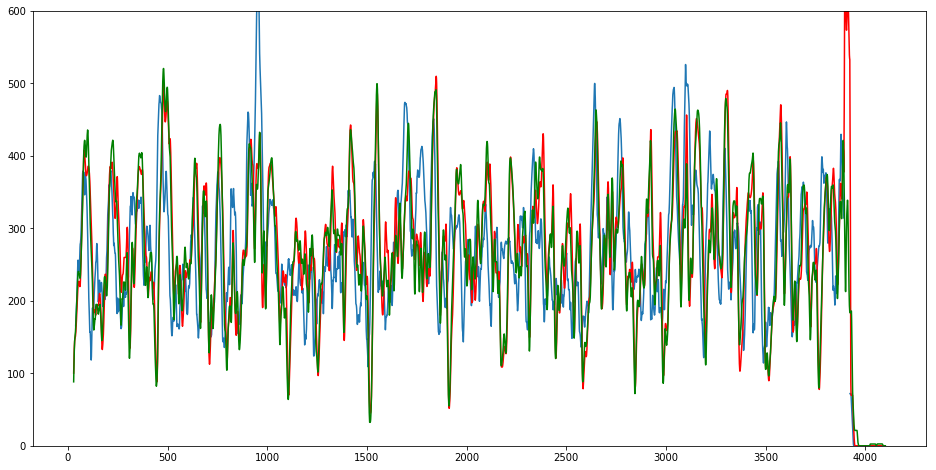

In [22]:
plt.figure(figsize=(16,8))
actual.watts.rolling(30).mean().plot()
course.Power.rolling(30).mean().plot(c='r')
courseP.Power.rolling(30).mean().plot(c='g')
plt.ylim((0,600))


In [23]:
actual.watts.mean(),course.Power.mean(), courseP.Power.mean()

(256.452125061065, 263.350742165532, 259.4035827060114)

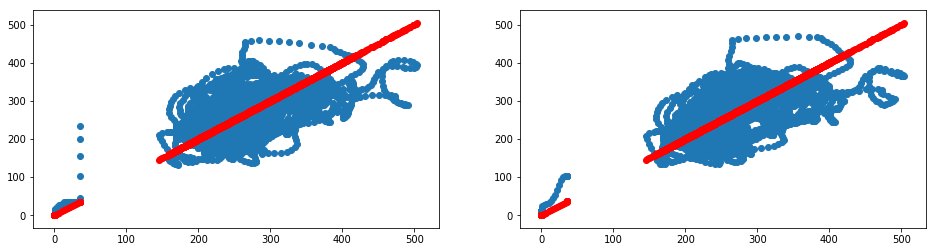

In [24]:
fig,ax=plt.subplots(1,2,figsize=(16,4))
ax[0].scatter(x=actual.watts.rolling(60).mean(),y=course.Power.rolling(60).mean())
ax[0].scatter(x=actual.watts.rolling(60).mean(),y=actual.watts.rolling(60).mean(),c='r')
ax[1].scatter(x=actual.watts.rolling(60).mean(),y=courseP.Power.rolling(60).mean())
ax[1].scatter(x=actual.watts.rolling(60).mean(),y=actual.watts.rolling(60).mean(),c='r')


In [25]:
powerCurve = []
course['PowerCap'] = course.Power
course.PowerCap[course.PowerCap>1200] = 1200
for t in range(5,len(course)):
               powerCurve += [[t, course.PowerCap.rolling(t).mean().max()]]
        

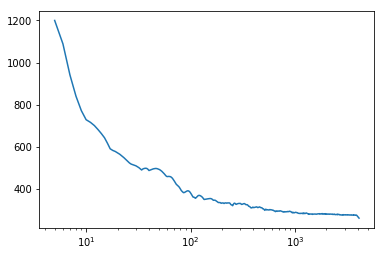

In [26]:
x,y = [i for i in zip(*powerCurve)]
plt.semilogx(x,y);

In [27]:
powerCurve[3595], powerCurve[3595][1]/mr

([3600, 276.1996448190884], 3.783556778343677)

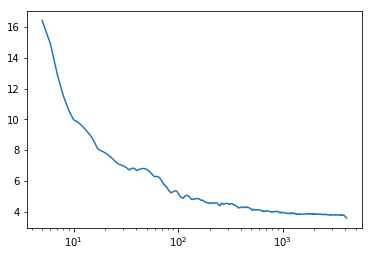

In [28]:
x,y = [i for i in zip(*powerCurve)]
ym =[i/mr for i in y]
plt.semilogx(x,ym);

In [32]:
powerCurve[3595], powerCurve[3595][1]/mr

([3600, 276.1996448190884], 3.783556778343677)

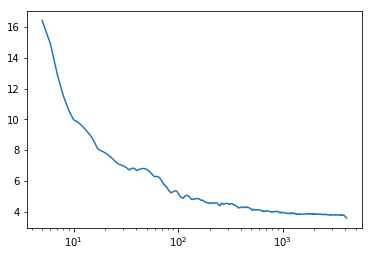

In [33]:
x,y = [i for i in zip(*powerCurve)]
ym =[i/mr for i in y]
plt.semilogx(x,ym);